<a href="https://colab.research.google.com/github/XanimGuliyeva/Generating_With_GAN/blob/main/Copy_of_Generating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Overview


This project focuses on training a Generative Adversarial Network (GAN) to generate new sneaker images. GANs consist of two neural networks, a Generator and a Discriminator, which are trained simultaneously through adversarial processes. The Generator aims to produce fake images that are indistinguishable from real ones, while the Discriminator tries to differentiate between real and generated images. The project explores various configurations, including different batch sizes, learning rates,number of layers to optimize the model's performance.


## Data

This dataset is a collection of 24,000 high-resolution left-facing sneaker images for machine learning. The images are categorized by brand, model, and color. All images are 1024 x 1024 and are gathered from various websites. The dataset can be used for tasks such as image classification, object detection, style transfer, or generative modeling of sneakers.

Link to download dataset: [link](https://www.kaggle.com/datasets/aahashemi/sneaker-image-dataset)

## Model

This project is an example of using a GAN to generate realistic images of sneakers. The model architecture consists of two main components: a generator and a discriminator. The generator takes a random noise vector as input and produces a synthetic image of a sneaker. The discriminator takes either a real or a fake image as input and tries to classify it as such. The two components are trained in an adversarial manner, where the generator tries to fool the discriminator and the discriminator tries to catch the generator.

## Implementation

The project is implemented in Python using the PyTorch library for building and training the DCGAN model. The training process includes:

* Data Preprocessing: Implement functions to load the sneaker image dataset
* Model Definition: Generator Network, Discriminator Network
* Training Implementation
* Define Loss Function and Optimizers
* Train the GAN
* Generating new sneakers and visualize generated images

## Results

In this project, we explored the training dynamics of a Generative Adversarial Network (GAN) for generating sneaker images, focusing on the interplay between Generator and Discriminator losses under various hyperparameter settings. By experimenting with different batch sizes and learning rates, we observed how these factors critically influence the training process, affecting stability, convergence speed, and image quality. Additionally, the structure of the Generator and Discriminator—particularly the number of layers and their configuration—played a significant role in the GAN's performance.

## Future Work

For future work, this project could be extended by integrating more sophisticated regularization techniques such as spectral normalization or gradient penalty to improve training stability and image quality. Exploring different network architectures, like conditional GANs for generating sneakers of specific types or colors, could offer more control over the generated outputs.

## Authors

Khanim Guliyeva

## Professor

Prof. Stefano Melacci

First of all, we download the dataset to use. It will be downloaded from the given website

In [ ]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/aahashemi/sneaker-image-dataset'
od.download(dataset_url)
#khanimguliyeva
#0ad1d81804e429dd87014012a0b6f22c

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: khanimguliyeva
Your Kaggle Key: ··········


100%|██████████| 1.09G/1.09G [00:53<00:00, 22.0MB/s]


In order start to code, we need to import some libraries such as torch, numpy etc.

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import sys

The configuration dictionary defines key parameters for a GAN training session on a sneaker image dataset. It specifies the dataset's location (**data_dir**), image dimensions (**image_size**), and includes options for batch sizes (**batch_sizes**) and learning rates (**learning_rates**) to experiment with training dynamics. The number of training epochs (**num_epochs**), Adam optimizer's beta1 parameter (**beta1**), GPU usage (**ngpu**), and the size of the generator's input noise vector (**latent_vector_size**) are also set, balancing between training efficiency and the capacity to generate diverse images. This configuration enables targeted experimentation to optimize the GAN's performance.

In [ ]:
# Ajusting parameters
configuration = {
    'data_dir': 'sneaker-image-dataset/',
    'image_size': 64,
    'batch_sizes': [64, 128],
    'learning_rates': [0.0002, 0.00005],
    'num_epochs': 5,
    'beta1': 0.5,
    'ngpu': 1,
    'latent_vector_size': 100,
}


The **get_data** function prepares the sneaker image dataset for training by loading images from a specified directory, applying transformations to resize, center crop, convert to tensors, and normalize the images. It then wraps the processed dataset into a DataLoader object, setting the batch size, enabling shuffling for randomness, and specifying two worker threads for efficient data loading. This setup streamlines feeding data into the GAN model for training.

In [ ]:
# Function to load the dataset from a specified directory, apply transformations, and return a DataLoader object.
def get_data(data_dir, image_size, batch_size):
    # Create a dataset of images located in the specified directory.
    # The images are processed with a series of transformations:
    dataset = dset.ImageFolder(root=data_dir,
                               transform=transforms.Compose([
                                   transforms.Resize(image_size),
                                   transforms.CenterCrop(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))
    # The DataLoader wraps the dataset and provides an iterable over the dataset with the following features:
    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=2)
    return dataloader

The **Generator** class, an essential component of the GAN, is designed to generate synthetic images from a latent noise vector. It leverages a sequence of transposed convolutional layers to upscale the input vector into a full-sized image (**64x64 pixels**). Each layer progressively increases the spatial dimensions while decreasing the depth, using batch normalization and **ReLU** **activations** to stabilize training and introduce non-linearity. The final output is produced through a **Tanh** **activation**, normalizing pixel values to between -1 and 1. This architecture enables the Generator to transform random noise into detailed images resembling the training dataset.
Generator will be in two different structure with different number of layers, features per layer:
- 6 layers
- 5 layers
- 3 layers

In [ ]:
# Define the Generator class, which inherits from nn.Module
class Generator(nn.Module):
    def __init__(self, ngpu=1):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        # Define the main module (a sequential container) which is a series of layers that define the generator model
        self.main = nn.Sequential(
            # Input is Z, going into a convolution
            nn.ConvTranspose2d(100, 1024, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),

            # Second layer: another transposed convolution that doubles the width and height dimensions of the feature maps
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            # Third layer: similar to the second, it further doubles the dimensions and reduces the depth
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            # Fourth layer: continues the pattern, doubling dimensions and reducing depth
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # Additional layer to refine the features before the final layer
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # Output layer, reducing the feature depth to match the image channels (e.g., 3 for RGB)
            nn.ConvTranspose2d(64, 3, 3, 1, 1, bias=False),
            nn.Tanh()
            # Final output size. (3) x 64 x 64
        )


    def forward(self, input):
        return self.main(input)

The **Discriminator** class functions as the adversarial counterpart to the Generator in a GAN, tasked with distinguishing real images from those synthesized by the Generator. It is structured as a series of convolutional layers that progressively downsample the input image, increasing its feature depth to extract discriminative features. Starting with the input image, each layer applies convolutions, **LeakyReLU activations** for non-linearity without blocking the gradient flow for negative values, and batch normalization for stabilizing learning. The architecture culminates in a convolution layer that collapses the feature maps to a single value, passed through a **Sigmoid activation** to output a probability indicating whether the input image is real or fake.
Discriminator will be in two different structure with different number of layers, features per layer:
- 6 layers
- 5 layers
- 3 layers

In [ ]:
# Define the Discriminator class, which inherits from nn.Module
class Discriminator(nn.Module):
    def __init__(self, ngpu=1):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        # Define the main module (a sequential container) which is a series of layers that define the discriminator model
        self.main = nn.Sequential(
            # First layer: a convolution that takes an image (3 channels) as input and outputs feature maps of size 64 x 32 x 32
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # Second layer: another convolution that reduces the spatial dimensions by half and increases depth
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Third layer: similar to the second, further reducing spatial dimensions and increasing depth
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # Additional layers for more complex feature extraction
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1024, 4, 2, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. (1024) x 2 x 2

            # Final layer to produce a single scalar output (probability)
            nn.Conv2d(1024, 1, 2, 1, 0, bias=False),
            nn.Sigmoid()
            # Final output size: (1), representing the probability that the input image is real
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

The first function, **save_model_checkpoint**, saves the current state of the generator and discriminator models, along with their optimizers, to a file. This enables the training process to be paused and resumed without loss of progress. It takes as arguments the models (**generator** and **discriminator**), their optimizers (**g_optimizer** and **d_optimizer**), and the filepath where the checkpoint will be saved.

The second function, **load_model_checkpoint**, loads the state of these models and optimizers from a saved checkpoint file, allowing for the continuation of training or the evaluation of the models on new data. It requires the same models and optimizers as input, along with the **filepath** of the saved checkpoint and a **device** to which the models should be loaded. This function is particularly useful for resuming training after an interruption or for deploying trained models on different hardware setups.

In [ ]:
def save_model_checkpoint(generator, discriminator, g_optimizer, d_optimizer, filepath):
    checkpoint = {
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
    }
    if g_optimizer is not None:
        checkpoint['g_optimizer_state_dict'] = g_optimizer.state_dict()
    if d_optimizer is not None:
        checkpoint['d_optimizer_state_dict'] = d_optimizer.state_dict()

    torch.save(checkpoint, filepath)
    print(f"Models and optimizers' states have been saved to {filepath}")



def load_model_checkpoint(generator, discriminator, g_optimizer, d_optimizer, filepath, device):
    checkpoint = torch.load(filepath, map_location=device)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
    d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
    print(f"Models and optimizers' states have been loaded from {filepath}")


This function trains the discriminator of a GAN by distinguishing between **real** and **generated (fake)** images. It starts by resetting the discriminator's gradients. It then creates labels for real and fake images, processes both real images and fake images generated by the generator through the discriminator, and calculates the loss for each. The losses from real and fake images are combined to update the discriminator's weights with backpropagation and optimization steps. The function returns the combined loss, providing insight into how well the discriminator is performing its task of classifying images as real or fake.

In [ ]:
# Function to train the discriminator.
def train_discriminator(images, d_optimizer, criterion, device, configuration, batch_size):
    # Zero the gradients of the discriminator before the forward pass (standard practice before a backward pass)
    d_optimizer.zero_grad()

    # Create tensors of the correct size filled with ones, to represent real and fake labels
    real_labels = torch.ones(images.size(0), device=device)
    fake_labels = torch.zeros(images.size(0), device=device)

    # Pass real images through the discriminator and calculate the loss against real labels
    real_output = discriminator(images)
    d_loss_real = criterion(real_output, real_labels)

    # Generate fake images using the generator
    noise = torch.randn(images.size(0), configuration['latent_vector_size'], 1, 1, device=device)
    fake_images = generator(noise)
    # Pass fake images through the discriminator and calculate the loss against fake labels
    fake_output = discriminator(fake_images)  # Detach to avoid gradients flowing into generator
    d_loss_fake = criterion(fake_output, fake_labels)

    # Combine the real and fake loss
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()

    # Return the discriminator's loss as a Python number
    return d_loss.item()

This function trains the generator component of a GAN, aiming to produce images that are classified as real by the discriminator. It begins by resetting the generator's gradients to avoid accumulation from previous iterations. The generator then creates a batch of fake images from random **noise vectors**. These generated images are labeled as "real" and fed into the discriminator to assess their authenticity. The loss is calculated based on how convincingly the images are classified as real, followed by backpropagation to adjust the generator's weights. The function returns the calculated loss

In [ ]:
# Function to train the generator part of a GAN.
# The generator's goal is to create images that the discriminator will classify as real.
def train_generator(g_optimizer, criterion, device, configuration, batch_size):

    # Reset the gradients for the generator before backpropagation.
    g_optimizer.zero_grad()

    # Generate a batch of noise vectors that will be used as input to the generator.
    noise = torch.randn(batch_size, configuration['latent_vector_size'], 1, 1, device=device)
    fake_images = generator(noise)

    # Create a tensor of ones to serve as "real" labels for the generated images.
    labels = torch.ones(batch_size, device=device)

    # Pass the fake images through the discriminator to get the classification.
    output = discriminator(fake_images).view(-1)
    g_loss = criterion(output, labels)

    # Backpropagate the loss for the generator, which calculates the gradients.
    g_loss.backward()
    # Update the weights of the generator based on the calculated gradients.
    g_optimizer.step()

    return g_loss.item(), fake_images

This function of **train_gan** arranges the main training loop for both the generator and discriminator within a GAN framework. It initializes the **binary cross-entropy loss** and **optimizers** for both networks, using the learning rate and **beta1** hyperparameter specified in the configuration. The training proceeds over several epochs, iterating through batches of real images from the dataloader. Within each iteration, the discriminator is trained to distinguish real from fake images, and the generator is trained to produce images that are classified as real by the discriminator. Losses from both networks are recorded for visualization. The training loop periodically outputs the current losses to monitor progress. After completing the training epochs, it visualizes the generated images to evaluate the generator's performance and plots the training losses to assess the overall training dynamics.

In [ ]:
# Function to conduct the main training loop for both the generator and discriminator of a GAN.
def train_gan(dataloader, device, configuration, lr, batch_size):
    # Initialize the Binary Cross-Entropy loss for both the generator and discriminator.
    criterion = nn.BCELoss()

    # Initialize the optimizers for both networks with specified learning rates and beta1 hyperparameter for the Adam optimizer.
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(configuration['beta1'], 0.999))
    g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(configuration['beta1'], 0.999))

    # Lists to accumulate losses for visualization.
    G_losses = []
    D_losses = []

    # Notify the start of the training loop.
    print("Starting Training Loop...")
    # Iterate over the entire dataset for a number of epochs specified in the configuration.
    for epoch in range(configuration['num_epochs']):
        # Iterate over the batches of the dataset.
        for i, (images, _) in enumerate(dataloader):

            # Ensure the images are on the correct device.
            images = images.to(device)

            # Train the discriminator with both real and fake images, record the loss.
            d_loss = train_discriminator(images, d_optimizer, criterion, device, configuration, batch_size)
            D_losses.append(d_loss)

            # Train the generator, record the loss.
            g_loss, _ = train_generator(g_optimizer, criterion, device, configuration, batch_size)
            G_losses.append(g_loss)

            # Periodically print the losses to monitor the training progress.
            if i % 50 == 0:
                print(f'[{epoch+1}/{configuration["num_epochs"]}][{i}/{len(dataloader)}] '
                      f'Loss_D: {d_loss:.4f}, Loss_G: {g_loss:.4f}')

    # After training, visualize the generated images to inspect the generator's performance.
    visualize_generated_images(generator, device, configuration)
    # Plot the recorded training losses for both the generator and discriminator to evaluate the training process.
    plot_training_losses(G_losses, D_losses)

    # Save models and optimizers' states at the end of training
    save_model_checkpoint(generator, discriminator, g_optimizer, d_optimizer, "gan_checkpoint.pth")

visualize_generated_images is designed to visually display images generated by the GAN's Generator. This function, plot_training_losses, is designed to graphically represent the training losses of both the generator and discriminator

In [ ]:
# Function to visualize images generated by the GAN's generator.
def visualize_generated_images(generator, device, configuration, title="Generated Images"):
    with torch.no_grad():
        fixed_noise = torch.randn(64, configuration['latent_vector_size'], 1, 1, device=device)
        # Generate a batch of images using the fixed noise vector.
        fake_images = generator(fixed_noise).detach().cpu()

    # Set up a matplotlib figure with a specified size.
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1,2,0)))
    plt.show()

# Function to plot the training losses for the generator and discriminator.
def plot_training_losses(G_losses, D_losses, title="Generator and Discriminator Loss During Training"):
    plt.figure(figsize=(8,4))
    plt.title(title)
    plt.plot(G_losses, label="Generator")
    plt.plot(D_losses, label="Discriminator")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

This part starts by setting the computation device to GPU if available and specified by the ngpu configuration; otherwise, it defaults to CPU. The training execution iterates over combinations of batch sizes and learning rates specified in the configuration dictionary. For each combination, it loads the dataset using the get_data function, which applies necessary transformations and returns a DataLoader object providing batches of images. The script logs the current batch size and learning rate being used, then calls the train_gan function to start the training process with these parameters.

No checkpoint found. Starting training from scratch.

Training with batch size 64 and learning rate 0.0002
Starting Training Loop...
[1/5][0/375] Loss_D: 1.4288, Loss_G: 4.2667
[1/5][50/375] Loss_D: 0.0058, Loss_G: 9.3096
[1/5][100/375] Loss_D: 0.2160, Loss_G: 4.5224
[1/5][150/375] Loss_D: 0.0855, Loss_G: 6.4221
[1/5][200/375] Loss_D: 2.0449, Loss_G: 1.3874
[1/5][250/375] Loss_D: 1.3998, Loss_G: 0.7706
[1/5][300/375] Loss_D: 0.9100, Loss_G: 1.2951
[1/5][350/375] Loss_D: 0.9516, Loss_G: 1.1859
[2/5][0/375] Loss_D: 1.0502, Loss_G: 1.2187
[2/5][50/375] Loss_D: 0.7807, Loss_G: 1.5123
[2/5][100/375] Loss_D: 1.0979, Loss_G: 1.1246
[2/5][150/375] Loss_D: 0.8805, Loss_G: 1.6202
[2/5][200/375] Loss_D: 1.8456, Loss_G: 4.6301
[2/5][250/375] Loss_D: 0.9396, Loss_G: 2.1641
[2/5][300/375] Loss_D: 1.0390, Loss_G: 2.7128
[2/5][350/375] Loss_D: 1.0648, Loss_G: 1.3918
[3/5][0/375] Loss_D: 1.3260, Loss_G: 1.6802
[3/5][50/375] Loss_D: 0.9586, Loss_G: 3.0159
[3/5][100/375] Loss_D: 0.9014, Loss_G: 1.3873
[3

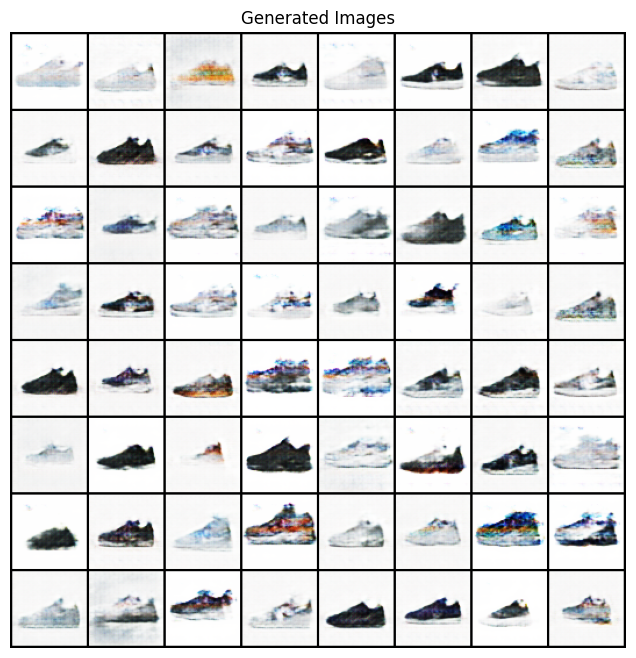

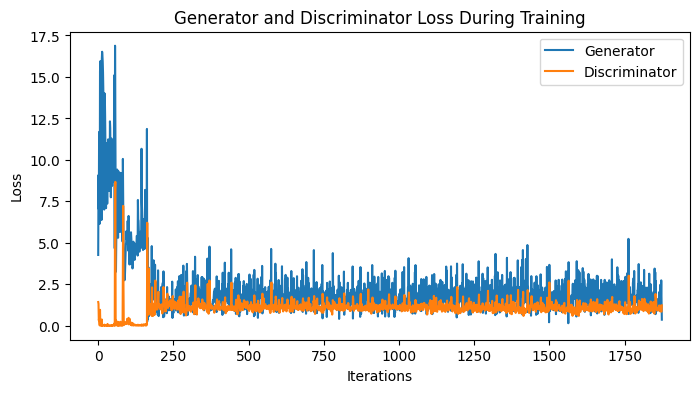

Models and optimizers' states have been saved to gan_checkpoint.pth

Training with batch size 64 and learning rate 5e-05
Starting Training Loop...
[1/5][0/375] Loss_D: 1.8554, Loss_G: 0.6311
[1/5][50/375] Loss_D: 0.8272, Loss_G: 1.3325
[1/5][100/375] Loss_D: 0.5885, Loss_G: 0.8307
[1/5][150/375] Loss_D: 0.9397, Loss_G: 1.3880
[1/5][200/375] Loss_D: 0.5275, Loss_G: 2.0654
[1/5][250/375] Loss_D: 0.8697, Loss_G: 1.4033
[1/5][300/375] Loss_D: 0.8282, Loss_G: 2.5660
[1/5][350/375] Loss_D: 0.5101, Loss_G: 1.6024
[2/5][0/375] Loss_D: 0.8096, Loss_G: 1.4200
[2/5][50/375] Loss_D: 0.3893, Loss_G: 1.9949
[2/5][100/375] Loss_D: 0.6935, Loss_G: 1.6897
[2/5][150/375] Loss_D: 0.7608, Loss_G: 2.6872
[2/5][200/375] Loss_D: 0.6514, Loss_G: 2.0143
[2/5][250/375] Loss_D: 0.7354, Loss_G: 1.9466
[2/5][300/375] Loss_D: 0.9155, Loss_G: 2.2951
[2/5][350/375] Loss_D: 0.7988, Loss_G: 1.5130
[3/5][0/375] Loss_D: 1.3292, Loss_G: 2.9586
[3/5][50/375] Loss_D: 0.4168, Loss_G: 1.7861
[3/5][100/375] Loss_D: 0.8695, Los

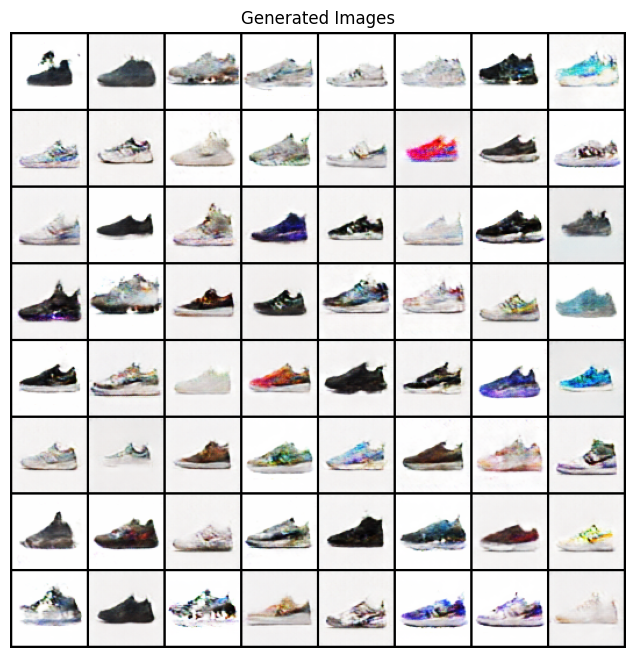

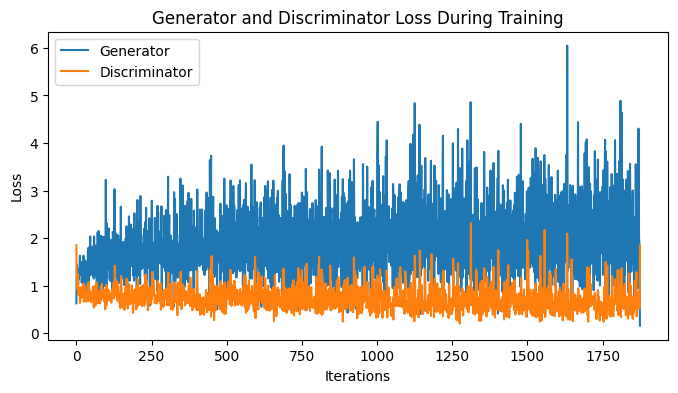

Models and optimizers' states have been saved to gan_checkpoint.pth

Training with batch size 128 and learning rate 0.0002
Starting Training Loop...
[1/5][0/188] Loss_D: 1.8679, Loss_G: 11.4472
[1/5][50/188] Loss_D: 0.7866, Loss_G: 1.5803
[1/5][100/188] Loss_D: 0.8822, Loss_G: 1.8637
[1/5][150/188] Loss_D: 0.9754, Loss_G: 1.4384
[2/5][0/188] Loss_D: 2.2753, Loss_G: 4.8410
[2/5][50/188] Loss_D: 0.9685, Loss_G: 4.2270
[2/5][100/188] Loss_D: 1.0522, Loss_G: 1.6862
[2/5][150/188] Loss_D: 1.1435, Loss_G: 1.2015
[3/5][0/188] Loss_D: 1.2943, Loss_G: 2.5611
[3/5][50/188] Loss_D: 0.7504, Loss_G: 1.7634
[3/5][100/188] Loss_D: 1.2832, Loss_G: 3.3035
[3/5][150/188] Loss_D: 1.3550, Loss_G: 1.1502
[4/5][0/188] Loss_D: 0.9352, Loss_G: 2.1385
[4/5][50/188] Loss_D: 1.0016, Loss_G: 2.6147
[4/5][100/188] Loss_D: 0.9793, Loss_G: 2.1556
[4/5][150/188] Loss_D: 0.8079, Loss_G: 2.6272
[5/5][0/188] Loss_D: 0.9386, Loss_G: 0.9424
[5/5][50/188] Loss_D: 0.4874, Loss_G: 3.5327
[5/5][100/188] Loss_D: 0.7588, Loss_G

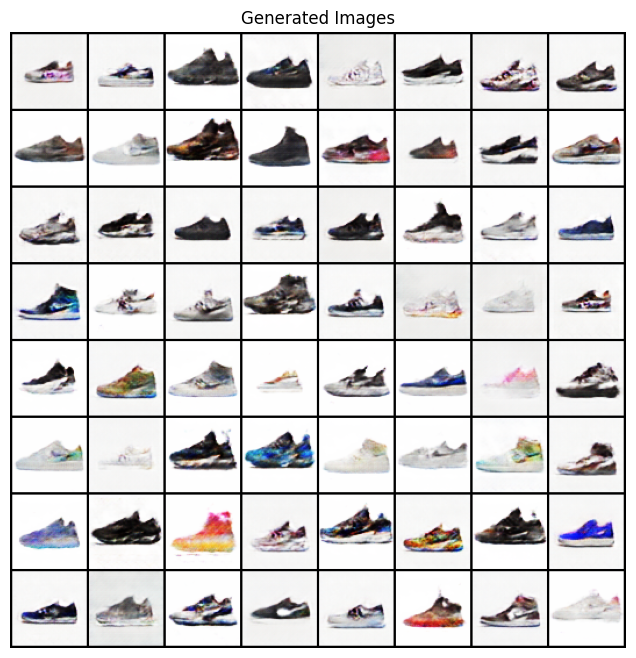

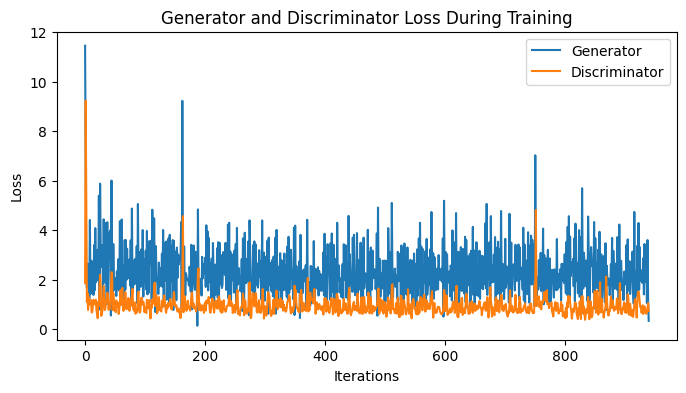

Models and optimizers' states have been saved to gan_checkpoint.pth

Training with batch size 128 and learning rate 5e-05
Starting Training Loop...
[1/5][0/188] Loss_D: 2.2413, Loss_G: 0.5945
[1/5][50/188] Loss_D: 0.4239, Loss_G: 2.0055
[1/5][100/188] Loss_D: 0.4454, Loss_G: 1.9919
[1/5][150/188] Loss_D: 0.6002, Loss_G: 2.6202
[2/5][0/188] Loss_D: 1.8466, Loss_G: 3.3295
[2/5][50/188] Loss_D: 0.3692, Loss_G: 3.2445
[2/5][100/188] Loss_D: 0.3960, Loss_G: 2.0467
[2/5][150/188] Loss_D: 0.1792, Loss_G: 3.5587
[3/5][0/188] Loss_D: 2.2379, Loss_G: 3.3764
[3/5][50/188] Loss_D: 0.6112, Loss_G: 2.4105
[3/5][100/188] Loss_D: 0.5661, Loss_G: 1.5516
[3/5][150/188] Loss_D: 0.3960, Loss_G: 1.5502
[4/5][0/188] Loss_D: 2.9826, Loss_G: 2.5280
[4/5][50/188] Loss_D: 0.4771, Loss_G: 2.1809
[4/5][100/188] Loss_D: 0.6530, Loss_G: 1.2131
[4/5][150/188] Loss_D: 0.5178, Loss_G: 3.2395
[5/5][0/188] Loss_D: 1.4220, Loss_G: 2.9042
[5/5][50/188] Loss_D: 0.7795, Loss_G: 0.8732
[5/5][100/188] Loss_D: 0.6046, Loss_G: 

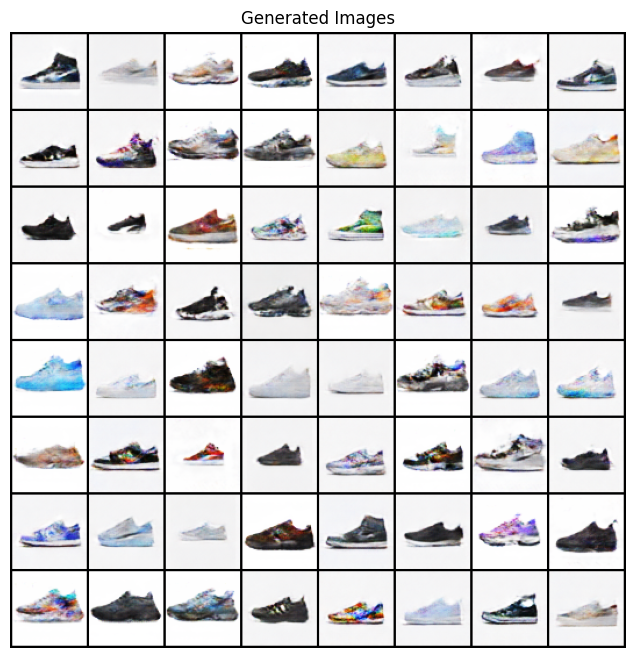

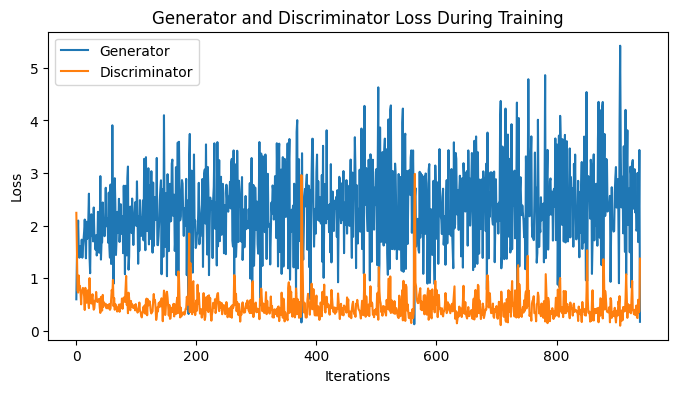

Models and optimizers' states have been saved to gan_checkpoint.pth
Models and optimizers' states have been saved to gan_checkpoint.pth
Training completed and models saved.


In [ ]:
# Training Execution
if __name__ == "__main__":

    device = torch.device("cuda:0" if (torch.cuda.is_available() and configuration['ngpu'] > 0) else "cpu")

    discriminator = Discriminator().to(device)
    generator = Generator().to(device)

    checkpoint_path = "gan_checkpoint.pth"
    try:
        load_model_checkpoint(generator, discriminator, None, None, checkpoint_path, device)
        print("Checkpoint loaded successfully.")
    except FileNotFoundError:
        print("No checkpoint found. Starting training from scratch.")

    # Begin iterating over the predefined batch sizes and learning rates specified in the configuration.
    for batch_size in configuration['batch_sizes']:

        # apply necessary transformations, and provide batches of data.
        dataloader = get_data(configuration['data_dir'], configuration['image_size'], batch_size)
        # Iterate over each learning rate for the current batch size.
        for lr in configuration['learning_rates']:
            # Log the current batch size and learning rate being used for training.
            print(f"\nTraining with batch size {batch_size} and learning rate {lr}")

            train_gan(dataloader, device, configuration, lr, batch_size)

    # Save final model states
    save_model_checkpoint(generator, discriminator, None, None, checkpoint_path)
    print("Training completed and models saved.")

Visualize the model

In [ ]:
model = torch.load('gan_checkpoint.pth')
print(model)

{'generator_state_dict': OrderedDict([('main.0.weight', tensor([[[[-1.7704e-02, -6.3799e-03,  7.4747e-03, -1.6666e-02],
          [-1.4305e-02, -4.9916e-04, -5.8247e-03, -4.1476e-03],
          [ 8.8128e-03, -7.4825e-03, -5.6725e-03,  1.4975e-02],
          [-2.0745e-02, -2.5870e-02, -1.7881e-02, -8.4860e-03]],

         [[ 9.1907e-04, -1.2765e-02,  7.8237e-03, -1.1526e-02],
          [-8.6159e-04,  1.6907e-03,  9.1255e-03, -1.3610e-02],
          [ 9.7734e-03,  7.2015e-03,  1.6844e-02,  5.9833e-03],
          [-3.0048e-02, -2.0098e-02, -3.4850e-02,  1.5881e-04]],

         [[ 2.8454e-02,  2.6259e-02,  2.6412e-02, -7.7168e-03],
          [-1.0379e-03,  1.3381e-02, -1.7754e-03,  6.6460e-03],
          [ 4.0612e-03,  3.5011e-05, -1.0385e-03,  1.0064e-02],
          [ 5.0438e-04,  9.4954e-03, -8.2413e-03,  6.9345e-03]],

         ...,

         [[-8.8495e-03, -1.3258e-02, -7.1857e-03, -6.1712e-03],
          [-6.6637e-03, -1.2014e-02,  4.5602e-02,  8.1619e-03],
          [-1.0728e-02,  1.